In [20]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.io as sio
import time

In [17]:
from google.colab import drive
drive.mount('/content/gdrive')   

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [18]:
import os
code_path = "/content/gdrive/MyDrive/cse512hw5/mnist_clustering_release_new/"
os.chdir(code_path)

In [19]:
data = sio.loadmat('mnist.mat')
X = data['trainX'].astype(float)/255
y = data['trainY'][0,:]
idx = np.less(y,5)
X = X[idx,:]
y = y[idx]
X = X[:1000,:]
y = y[:1000]
m,n = X.shape
test_idx = np.array(range(25))
print(X.shape,y.shape)


(1000, 784) (1000,)


In [21]:
def get_distance(X,z,D1=None): 
    return np.sum(np.power(X - z, 2), axis=1)

# Don't change this! Return what you see printed out.
print(np.sum(get_distance(X,np.array(range(n)))))

160239119987.1912


In [22]:
# init centroids with random samples  
def initCentroids(dataSet, k):  
    numSamples, dim = dataSet.shape
    centroids = np.zeros((k, dim)) 
    for i in range(k):  
        centroids[i, :] = dataSet[i, :]  
    return centroids  


def kmeans(X, k, iter = 10):  
    numSamples = X.shape[0]  
    # first column stores which cluster this sample belongs to,  
    # second column stores the error between this sample and its centroid  
    clusterChanged = True  
    
    ## step 1: init centroids  
    centroids = initCentroids(X, k)  
    class_membership = np.zeros(X.shape[0], dtype=int)
    i = 0
    while clusterChanged and i < iter:  
        clusterChanged = False
        for i in range(numSamples):  #range
            ## step 2: find the centroid who is closest  
            
            new_index = np.argmin(get_distance(centroids, X[i]))

            ## step 3: update its cluster 
            if class_membership[i] != new_index:  
                clusterChanged = True  
            class_membership[i] = new_index

            ## step 4: update centroids  
        for i in range(k):  
            centroids = np.mean(X[np.where(np.equal(class_membership,i))[0]], axis=0)
        i += 1
  
    print ('Succefully, cluster complete!')  
    return class_membership  



#use this to plot your final kmeans results
def plot_class_membership(class_membership, K):
    plt.figure(figsize=(20,10))
    max_per_class = 0
    for k in range(K):
        per_class = np.equal(class_membership,k)
        if sum(per_class) > max_per_class:
            max_per_class = sum(per_class)
    
    for k in range(K):
        S = np.where(np.equal(class_membership,k))[0]
        for ii in range(len(S)):
            i = S[ii]
            plt.subplot(K,max_per_class,max_per_class*k+ii+1)
            plt.imshow(np.reshape(X[i,:],(28,28)))
        
    
def overall_purity(class_membership, K=10):
    purity = 0.
    for k in range(K):
        S = np.where(np.equal(class_membership,k))[0]
        unique, counts = np.unique(y[:len(class_membership)][np.equal(class_membership, k)], return_counts=True)
        purity += np.max(counts)
    return purity/len(class_membership)


# 10 iterations after running k-means on only the First 25 datapoints, up to 3 digits after the decimal. Plot also the clustering result.

Succefully, cluster complete!
Purity: 0.68


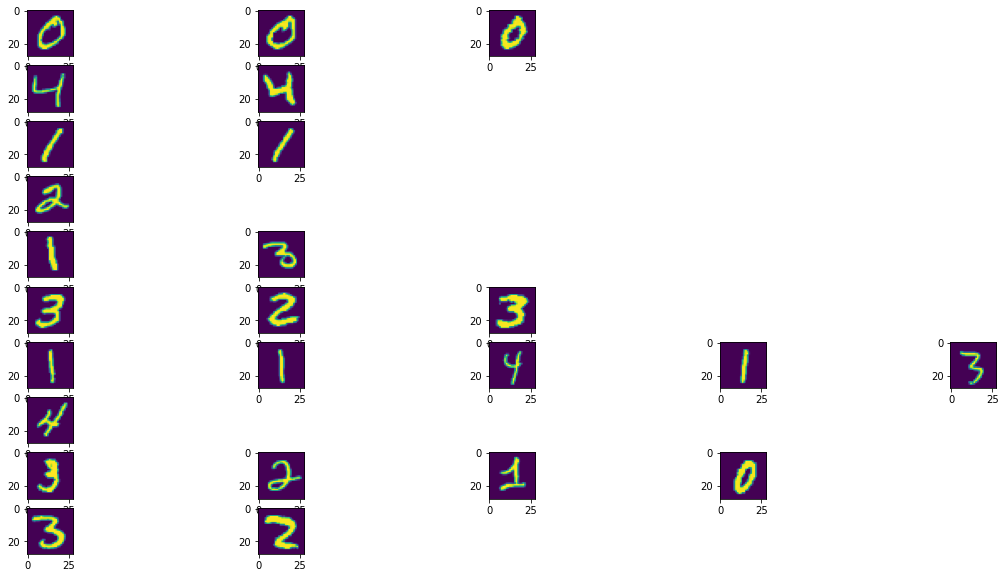

In [24]:
# Run 10 iterations
class_membership = kmeans(X[:25], 10)
plot_class_membership(class_membership, 10)
print('Purity:', overall_purity(class_membership))

# Implement PCA, and reduce the data dimension to d = 10, 100, and 500.

In [31]:
time_begin = time.time()
X = X - np.outer(np.ones(X.shape[0]), np.mean(X, axis=0))
U, Sigma, Vh = np.linalg.svd(X, full_matrices=False, compute_uv=True)

for d in [10, 100, 500]:
    print('Reduce the dimension =', d)
    X_SVD = np.dot(U[:, :d], np.diag(Sigma[:d]))
    class_membership = kmeans(X_SVD, 10)
    purity = overall_purity(class_membership)
    print('Finally Purity:', purity)

time_end = time.time()
print("time cost:", time_end-time_begin)

Reduce the dimension = 10
Succefully, cluster complete!
Finally Purity: 0.804
Reduce the dimension = 100
Succefully, cluster complete!
Finally Purity: 0.75
Reduce the dimension = 500
Succefully, cluster complete!
Finally Purity: 0.739
time cost: 0.674248456954956


# Use random hashing (as promoted by the JL lemma) and reduce the feature dimension

In [33]:
time_begin = time.time()
for d in [10, 100, 500]:
    print('Result the dimension =', d)
    A = np.random.normal(0, 1, size=(d, X.shape[1]))
    X_jL = (1 / np.sqrt(d)) * A.dot(X.T).T
    class_membership = kmeans(X_jL, 10)
    purity = overall_purity(class_membership)
    print('Finally Purity:', purity)

time_end = time.time()
print("time cost:", time_end-time_begin)

Result the dimension = 10
Succefully, cluster complete!
Finally Purity: 0.472
Result the dimension = 100
Succefully, cluster complete!
Finally Purity: 0.727
Result the dimension = 500
Succefully, cluster complete!
Finally Purity: 0.75
time cost: 0.2876701354980469


# Isomap, LLE

In [34]:
from scipy.sparse.csgraph import shortest_path

def isomap(X, threshold, dimension):
    dist = np.zeros((X.shape[0], X.shape[0]))
    for i in range(X.shape[0]):
        dist[i] = get_distance(X, X[i, :])
    adj = np.zeros((X.shape[0], X.shape[0])) + np.inf
    adj[dist<threshold] = dist[dist<threshold]
    dist_matrix = shortest_path(csgraph=adj)
    h = np.eye(X.shape[0]) - (1/X.shape[0]) * np.ones((X.shape[0], X.shape[0]))
    c = -1/(2*X.shape[0]) * h.dot(dist_matrix).dot(h)
    evals, evecs = np.linalg.eig(c)
    idx = evals.argsort()[::-1]
    evals, evecs = evals[idx][:dimension], evecs[:, idx][:, :dimension]
    z = evecs.dot(np.diag(evals**(-1/2)))

    return z.real

In [35]:
time_begin = time.time()
for d in [10, 100, 500]:
    print('Result the dimension =', d)
    X_isomap = isomap(X, 1000, d)
    class_membership = kmeans(X_isomap, 10)
    purity = overall_purity(class_membership)
    print('Finally Purity:', purity)

time_end = time.time()
print("time cost:", time_end-time_begin)

Result the dimension = 10
Succefully, cluster complete!
Finally Purity: 0.604
Result the dimension = 100
Succefully, cluster complete!
Finally Purity: 0.302
Result the dimension = 500
Succefully, cluster complete!
Finally Purity: 0.243
time cost: 47.24965167045593


# Use sklearn's t-SNE to to reduce dimension to 1,2,3

In [36]:
from sklearn.manifold import TSNE

time_begin = time.time()

for d in [1, 2, 3]:
    print('Result the dimension =', d)
    X_embedded = TSNE(n_components=d, learning_rate='auto', init='random').fit_transform(X)
    class_membership = kmeans(X_embedded, 10)
    purity = overall_purity(class_membership)
    print('Finally Purity:', purity)

time_end = time.time()
print("time cost:", time_end-time_begin)

Result the dimension = 1
Succefully, cluster complete!
Finally Purity: 0.907
Result the dimension = 2
Succefully, cluster complete!
Finally Purity: 0.893
Result the dimension = 3
Succefully, cluster complete!
Finally Purity: 0.846
time cost: 34.38864779472351
